In [2]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install requests pandas sklearn matplotlib sktime

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
input_covid_data = "./20201112-covid19-data.csv"
input_features_data = "./census_feature_2016.csv"

In [100]:
# general helpers
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
# regression functions
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [5]:
covid_data = pd.read_csv(input_covid_data)
feature_data = pd.read_csv(input_features_data)

In [6]:
print(covid_data.columns)
print(feature_data.columns)

Index(['pruid', 'prname', 'prnameFR', 'date', 'numconf', 'numprob',
       'numdeaths', 'numtotal', 'numtested', 'numrecover', 'percentrecover',
       'ratetested', 'numtoday', 'percentoday', 'ratetotal', 'ratedeaths',
       'numdeathstoday', 'percentdeath', 'numtestedtoday', 'numrecoveredtoday',
       'percentactive', 'numactive', 'rateactive', 'numtotal_last14',
       'ratetotal_last14', 'numdeaths_last14', 'ratedeaths_last14',
       'numtotal_last7', 'ratetotal_last7', 'numdeaths_last7',
       'ratedeaths_last7', 'avgtotal_last7', 'avgincidence_last7',
       'avgdeaths_last7', 'avgratedeaths_last7'],
      dtype='object')
Index(['Province_Name', 'Pop', 'Land_Area', 'Pop_Den', 'Avg_Age_Both',
       'Avg_Age_M', 'Avg_Age_F', 'Avg_HS', 'Total_#_Income_Earner',
       'Med_Income', 'Avg_CD'],
      dtype='object')


In [16]:
cols = ['date', 'prname', 'numtoday']
provincial_covid_data = covid_data[covid_data['prname'] != 'Canada']
provincial_covid_data = provincial_covid_data[provincial_covid_data['prname'] != 'Repatriated travellers']
provincial_covid_data = provincial_covid_data[provincial_covid_data['date'] >= '2020-03-11']
provincial_covid_data = provincial_covid_data[cols]

# canada_data = canada_data[canada_data['prname'] != 'Quebec']
# print(provincial_covid_data[cols])

            date                 prname  numtoday
57    2020-03-11       British Columbia         0
58    2020-03-11                Alberta         0
59    2020-03-11           Saskatchewan         0
60    2020-03-11               Manitoba         0
61    2020-03-11                Ontario         8
...          ...                    ...       ...
3740  2020-11-11            Nova Scotia         2
3741  2020-11-11   Prince Edward Island         1
3742  2020-11-11                  Yukon         0
3743  2020-11-11  Northwest Territories         1
3744  2020-11-11                Nunavut         1

[3198 rows x 3 columns]


In [33]:
ON_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Ontario']['numtoday'].reset_index(drop=True)
QC_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Quebec']['numtoday'].reset_index(drop=True)
AB_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Alberta']['numtoday'].reset_index(drop=True)
BC_covid = provincial_covid_data[provincial_covid_data['prname'] == 'British Columbia']['numtoday'].reset_index(drop=True)
NS_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Nova Scotia']['numtoday'].reset_index(drop=True)
YU_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Yukon']['numtoday'].reset_index(drop=True)
NW_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Northwest Territories']['numtoday'].reset_index(drop=True)
NV_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Nunavut']['numtoday'].reset_index(drop=True)
PEI_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Prince Edward Island']['numtoday'].reset_index(drop=True)
MB_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Manitoba']['numtoday'].reset_index(drop=True)
SS_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Saskatchewan']['numtoday'].reset_index(drop=True)
NL_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Newfoundland and Labrador']['numtoday'].reset_index(drop=True)
NB_covid = provincial_covid_data[provincial_covid_data['prname'] == 'New Brunswick']['numtoday'].reset_index(drop=True)

In [54]:
ON_features = feature_data[feature_data['Province_Name'] == 'Ontario']
QC_features = feature_data[feature_data['Province_Name'] == 'Quebec']
AB_features = feature_data[feature_data['Province_Name'] == 'Alberta']
BC_features = feature_data[feature_data['Province_Name'] == 'British Columbia']
NS_features = feature_data[feature_data['Province_Name'] == 'Nova Scotia']
YU_features = feature_data[feature_data['Province_Name'] == 'Yukon']
NW_features = feature_data[feature_data['Province_Name'] == 'Northwest Territories']
NV_features = feature_data[feature_data['Province_Name'] == 'Nunavut']
PEI_features = feature_data[feature_data['Province_Name'] == 'Prince Edward Island']
MB_features = feature_data[feature_data['Province_Name'] == 'Manitoba']
SS_features = feature_data[feature_data['Province_Name'] == 'Saskatchewan']
NL_features = feature_data[feature_data['Province_Name'] == 'Newfoundland and Labrador']
NB_features = feature_data[feature_data['Province_Name'] == 'New Brunswick']

In [114]:
# Custom Modeling
def create_rolling_window(data, window_size=7):
    data = data[data > 0] # remove missing days
    ws = window_size + 1
    x_data = data[:-1]
    
    x_data = np.reshape(x_data, (-1,1))
    temp_data = np.roll(x_data, -1)
    for x in range(1, ws):
        # Stack
        x_data = np.concatenate((x_data[:-1], temp_data[:-1]), 1)
        # Step, roll left by 1
        temp_data = np.roll(temp_data, -1)[:-1]
    
    cols = ["day{}".format(i) for i in range(1,ws)] + ['newDay']
    return pd.DataFrame(x_data, columns=cols)

def split_train_test_val(data):
    # Divide into train,test,val sets
    # Take first 80% as train, next 10% as test and remainder as val
    ntrain,ntest = int(len(data) * 0.7), int(len(data) * 0.1)
    data = data.sample(frac=1)
    
    train = data[:ntrain].reset_index(drop=True)
#     test = data[ntrain:ntrain+ntest].reset_index(drop=True)
#     val = data[ntrain+ntest:].reset_index(drop=True)
    test = data[ntrain:].reset_index(drop=True)
    val = []
    return train, test, val

def add_features(df,features):
    # add_features(ON_covid, feature_data[feature_data['Province_Name'] == 'Ontario'])
    df['merger'] = 1
    features['merger'] = 1
    
    df = df.merge(features, how='outer', on='merger').drop(['merger','Province_Name'], axis=1)
    return df


In [95]:
def prepare_data(covid_df, features):
    rw = create_rolling_window(covid_df.values)
    rw_with_features = add_features(rw,features)
    
    return split_train_test_val(rw_with_features)

def split_xy(data):
    return data[data.columns.difference(['newDay'])], data['newDay']

In [115]:
ON_train, ON_test, ON_val = prepare_data(ON_covid, ON_features)
QC_train, QC_test, QC_val = prepare_data(QC_covid, QC_features)
AB_train, AB_test, AB_val = prepare_data(AB_covid, AB_features)
BC_train, BC_test, BC_val = prepare_data(BC_covid, BC_features)
NS_train, NS_test, NS_val = prepare_data(NS_covid, NS_features)
YU_train, YU_test, YU_val = prepare_data(YU_covid, YU_features)
NW_train, NW_test, NW_val = prepare_data(NW_covid, NW_features)
NV_train, NV_test, NV_val = prepare_data(NV_covid, NV_features)
PEI_train, PEI_test, PEI_val = prepare_data(PEI_covid, PEI_features)
MB_train, MB_test, MB_val = prepare_data(MB_covid, MB_features)
SS_train, SS_test, SS_val = prepare_data(SS_covid, SS_features)
NL_train, NL_test, NL_val = prepare_data(NL_covid, NL_features)
NB_train, NB_test, NB_val = prepare_data(NB_covid, NB_features)

<ipython-input-114-39e03c598ec8>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['merger'] = 1


In [109]:
print(ON_train)
# print(ON_covid[ON_covid > 0])

     day1  day2  day3  day4  day5  day6  day7  newDay       Pop  Land_Area  \
0     341   391   340   304   427   390   413     441  13448494  908699.33   
1     112   118   170   116   130   129   116     111  13448494  908699.33   
2    1042   851   827   834   934   896  1015     977  13448494  908699.33   
3     102    76   131   108   115   105   100      88  13448494  908699.33   
4      33    95    78    92   106    81    99     125  13448494  908699.33   
5     130   129   116   111   102   111   111     166  13448494  908699.33   
6     135   203   165   103   195   138   137     119  13448494  908699.33   
7     977   948  1050   987   998  1003  1132    1328  13448494  908699.33   
8     100    88   118   122   148   112   114     112  13448494  908699.33   
9     704   821   790   841   826   978  1042     851  13448494  908699.33   
10   1553   721   783   712   805   658   704     821  13448494  908699.33   
11    173   178   206   175   161   216   163     189  13448494 

In [111]:
def model_with_RF(train_data,test_data):
    x_train, y_train = split_xy(train_data)
    x_test, y_test = split_xy(test_data)
    
    model = RandomForestRegressor(n_estimators = 100, random_state = 0)
    model.fit(x_train,y_train)
    
    y_preds = model.predict(x_test)
    plt.plot(y_preds, label='preds')
    plt.plot(y_test, label='actual')
    plt.legend()
    
    print(np.mean(np.abs(y_preds-y_test))) # mean absolute error
    print(np.mean(np.power(y_preds-y_test,2))) # mean squared error

def model_with_LR(train_data,test_data):
    x_train, y_train = split_xy(train_data)
    x_test, y_test = split_xy(test_data)
    
    model = LinearRegression()
    model.fit(x_train,y_train)
    
    y_preds = model.predict(x_test)
    plt.plot(y_preds, label='preds')
    plt.plot(y_test, label='actual')
    plt.legend()
    
    print(np.mean(np.abs(y_preds-y_test))) # mean absolute error
    print(np.mean(np.power(y_preds-y_test,2))) # mean squared error

90.46130434782609
12968.934404347823


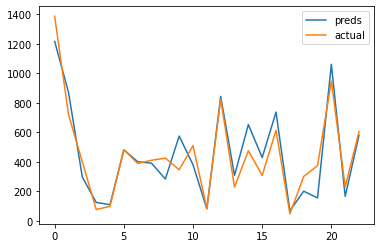

In [112]:
model_with_RF(ON_train,ON_test) # 80/10/10

87.52317969539527
17707.72225086121


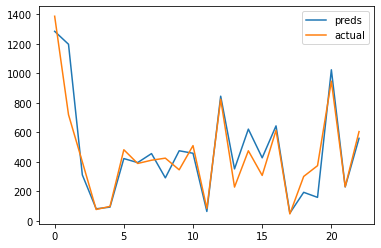

In [113]:
model_with_LR(ON_train,ON_test) #80/10/10

57.86357142857144
7247.742427142857


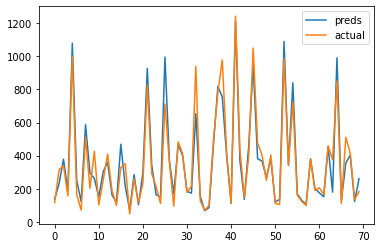

In [116]:
model_with_RF(ON_train,ON_test) # 70/30

57.07972935267857
9210.01873504775


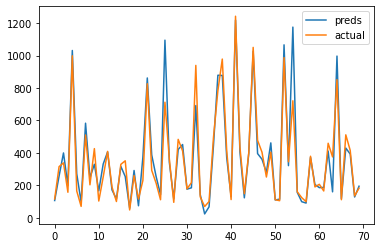

In [117]:
model_with_LR(ON_train,ON_test) #70/30

0.7188888888888889
0.7780555555555556


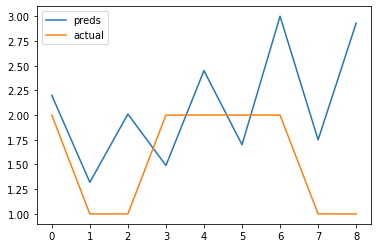

In [118]:
model_with_RF(PEI_train,PEI_test)